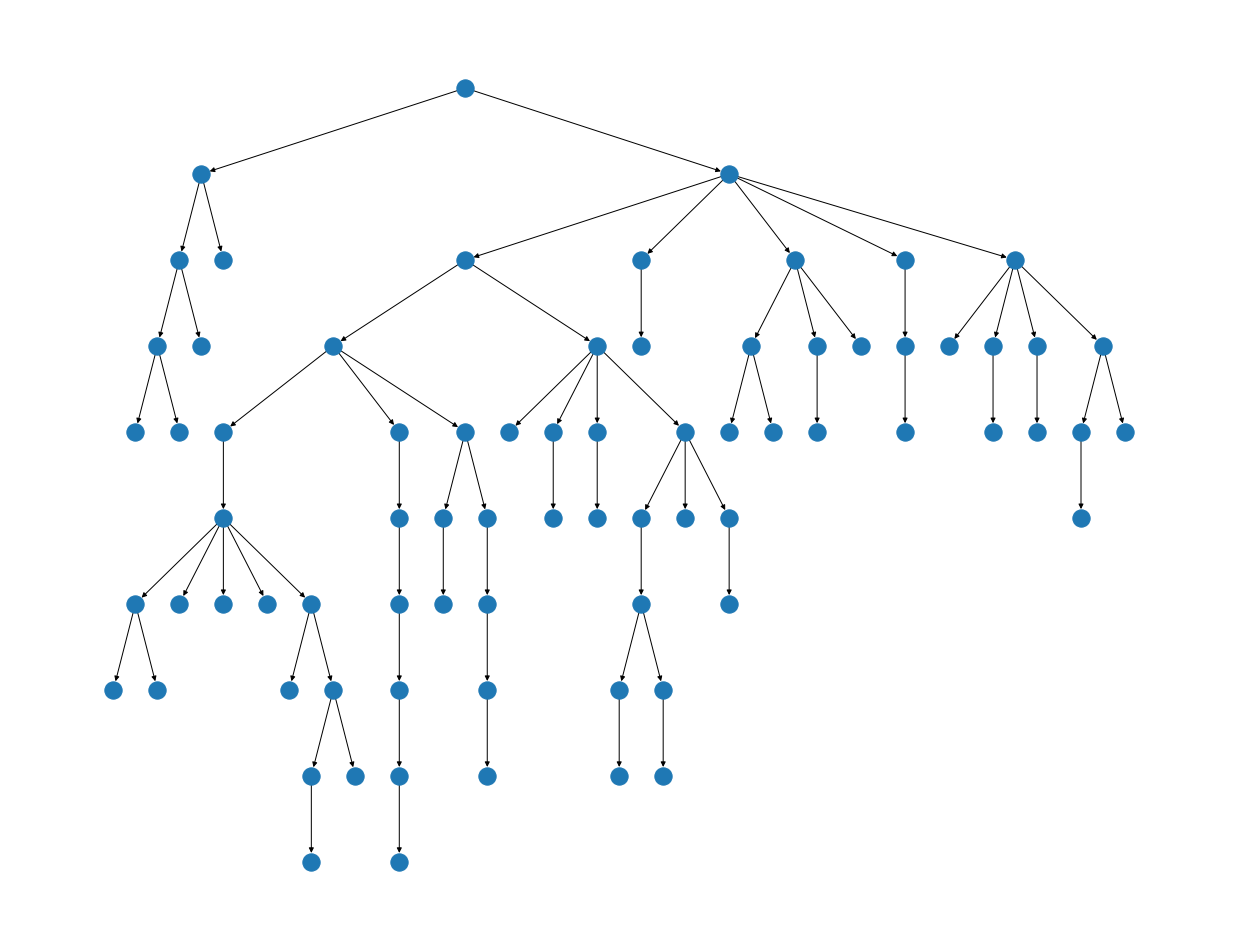

In [84]:
import matplotlib.pyplot as plt
import networkx as nx


def _draw(subtree_root):
    pos = {}
    contour = []
    for neighbor in tree.neighbors(subtree_root):
        neighbor_pos, neighbor_contour = _draw(neighbor)

        # +2 for the case where we have subtree of size 3: root and both children
        # in this case with +1 root will end up right above the left child due to //2
        shift = max(
            (x_left_max - x_right_min + 2
             for (_, x_left_max), (x_right_min, _) in zip(contour, neighbor_contour)),
            default = 0
        )

        # shift neighbor pos and contour
        pos.update({
            node: (x + shift, y)
            for node, (x, y) in neighbor_pos.items()
        })
        neighbor_contour = [
            (x_min + shift, x_max + shift)
            for x_min, x_max in neighbor_contour
        ]

        # This is the trickiest part. Here I merge contours.
        # The biggest problem here is the fact that they can have different sizes
        # and any one of them can be bigger.

        # where both contours exist, take left min as min and right max as max
        # (note that zip stops when either iterator is exhausted)
        contour[:min(len(contour), len(neighbor_contour))] = [
            (x_left_min, x_right_max)
            for (x_left_min, _), (_, x_right_max) in zip(contour, neighbor_contour)
        ]

        # if the neighbor contour was shallower than accumulated one, then we are finished
        # else we need to extend our merged contour with the neighbors contour values
        if len(contour) < len(neighbor_contour):
            contour.extend(neighbor_contour[len(contour):])

    if not contour:
        # if root is the only vertex, then position it at (0, 0)
        root_x = 0
    else:
        # else center it wrt. the next layer
        root_x = sum(contour[0]) // 2

    # add root position and shift all other nodes along y axis
    merged_pos = {
        subtree_root: (root_x, 0)
    }
    merged_pos.update({
        node: (x, y + 1)
        for node, (x, y) in pos.items()
    })
    
    # add root contour to merged contour
    merged_contour = [(root_x, root_x)] + contour

    return merged_pos, merged_contour


def draw(tree):
    tree_root = next(node for node in tree.nodes if tree.in_degree[node] == 0)
    assert all(
        tree.in_degree[node] == (1 if node != tree_root else 0)
        for node in tree.nodes
    )
    pos, _ = _draw(tree_root)

    # invert y axis
    pos = {
        node: (x, -y)
        for node, (x, y) in pos.items()
    }

    plt.figure(figsize=(17, 13))
    nx.draw(tree, pos)
    plt.show()


# In order to run upload graphml file and fix its name here...
graphml_filepath = './tree-example.xml'
tree = nx.read_graphml(graphml_filepath)
draw(tree)